In [1]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import csv
import pandas as pd
import random
from random import choice
from random import sample
from itertools import combinations

import metis # lulz


# Data load

In [2]:
# grap init
G_dblp = nx.Graph()


# dblp.tsv
with open('data/dblp/com-dblp/out.com-dblp.tsv', 'r') as file:
    for line in file:
        source, target = line.strip().split(' ')
        G_dblp.add_edge(int(source), int(target))

num_edges = G_dblp.number_of_edges()
num_nodes = G_dblp.number_of_nodes()


print("number of directed edges in dblp.tsv:", num_edges)
print("number of directed nodes in dblp.tsv:", num_nodes)

number of directed edges in dblp.tsv: 1049866
number of directed nodes in dblp.tsv: 317080


## Choosing random nodes for landmark

In [55]:
def generate_rng_landmark_list(graph, num_landmarks=20):
    """
    Generate a list of random landmarks from the given graph.

    Parameters:
    - graph: NetworkX graph
    - num_landmarks: Number of landmarks to generate (default is 20)
    Returns:
    - landmark_list: List of random landmarks
    """
    landmark_list = []

    for i in range(num_landmarks):
        random_node = choice(list(graph.nodes()))
        if random_node not in landmark_list:
            landmark_list.append(random_node)

    return landmark_list


## Calculating each node's degree

In [4]:
# WITH REGARD OR AREA REPULSION
# Top 20 degree nodes regardless of area of repulsion
N = 20

# Get the top nodes with the highest degree
top_nodes_degree = [node for node in sorted(G_dblp.nodes(), key=G_dblp.degree, reverse=True)][:N]

# Print the degree for each of the top nodes
for node in top_nodes_degree:
    node_degree = G_dblp.degree(node)
    print(f"The degree of node {node} is {node_degree}")



The degree of node 3336 is 343
The degree of node 3345 is 296
The degree of node 167 is 290
The degree of node 14690 is 269
The degree of node 13941 is 264
The degree of node 30095 is 244
The degree of node 13842 is 230
The degree of node 865 is 227
The degree of node 3298 is 225
The degree of node 13811 is 221
The degree of node 15326 is 219
The degree of node 3346 is 218
The degree of node 3326 is 218
The degree of node 1827 is 215
The degree of node 1833 is 215
The degree of node 13953 is 215
The degree of node 45 is 208
The degree of node 7227 is 207
The degree of node 2486 is 201
The degree of node 6319 is 201


In [5]:
def calculate_degree_centrality(graph, N=20):
    """
    Get the top nodes with the highest degree in the graph.

    Parameters:
    - graph: NetworkX graph
    - N: Number of top nodes to retrieve (default is 20)

    Returns:
    - degree_centrality: Dictionary of nodes with their degree centrality values
    """
    selected_nodes = []
    degree_centrality = {}

    top_nodes_degree = [node for node in sorted(graph.nodes(), key=graph.degree, reverse=True)]

    for node in top_nodes_degree:
        if not any(prev_node in graph.neighbors(node) for prev_node in selected_nodes):
            selected_nodes.append(node)
            degree_centrality[node] = graph.degree(node)
            if len(selected_nodes) == N:
                break

    return degree_centrality
# example usage
print(calculate_degree_centrality(G_dblp, N=20))

{3336: 343, 14690: 269, 13941: 264, 30095: 244, 13842: 230, 865: 227, 13811: 221, 15326: 219, 1827: 215, 1833: 215, 45: 208, 27138: 201, 1448: 191, 9401: 184, 7007: 183, 9800: 182, 10278: 182, 3300: 181, 2006: 180, 66102: 175}


## Calculate each's node closeness centrality (approximation)

In [6]:
def approximate_closeness_centrality(graph, num_seeds):
    # Select a sample of random seed nodes
    seed_nodes = random.sample(list(graph.nodes()), num_seeds)

    # Initialize the closeness centrality dictionary
    approx_closeness_centrality = {node: 0.0 for node in graph.nodes()}

    # Perform BFS computations from each seed node
    for seed_node in seed_nodes:
        distances = nx.single_source_shortest_path_length(graph, seed_node)
        for node, distance in distances.items():
            approx_closeness_centrality[node] += distance

    # Normalize the closeness centrality by the number of seed nodes
    for node in graph.nodes():
        approx_closeness_centrality[node] /= num_seeds

    return approx_closeness_centrality

In [7]:
def calculate_closeness_centrality(graph, N=20, num_seeds=20):
    """
    Calculate the approximate closeness centrality for a given graph.

    Parameters:
    - graph: NetworkX graph
    - N: Number of top nodes to select (default is 20)
    - num_seeds: Number of random seed nodes to use (default is 20)

    Returns:
    - closeness_centrality: Dictionary of nodes with their closeness centrality values
    """
    # Calculate approximate closeness centrality for each node
    approx_closeness_centrality = approximate_closeness_centrality(graph, num_seeds)

    # Initialize the list of selected nodes
    selected_nodes = []

    # Get the nodes sorted by closeness centrality
    sorted_nodes_closeness = [node for node in sorted(approx_closeness_centrality, key=approx_closeness_centrality.get) if approx_closeness_centrality[node] > 0]

    for node in sorted_nodes_closeness:
        # Check if the node is not in the neighborhood of any previously selected nodes
        if not any(prev_node in graph.neighbors(node) for prev_node in selected_nodes):
            selected_nodes.append(node)
            if len(selected_nodes) == N:
                break

    # Create a dictionary of nodes with their closeness centrality values
    closeness_centrality = {node: approx_closeness_centrality[node] for node in selected_nodes}

    return closeness_centrality

print(calculate_closeness_centrality(G_dblp, N=20, num_seeds=20))



{6574: 4.35, 6363: 4.4, 9800: 4.4, 45: 4.45, 13811: 4.45, 8385: 4.45, 2009: 4.5, 167: 4.5, 28231: 4.5, 7227: 4.5, 1448: 4.55, 4168: 4.55, 4560: 4.55, 865: 4.55, 58085: 4.55, 17659: 4.55, 1999: 4.6, 4807: 4.6, 2546: 4.6, 4788: 4.6}


## Calculate each's node betweeness centrality (approximation)

In [8]:
def approximate_betweenness_centrality(graph, num_seeds=20):
    # Select a sample of random seed nodes
    seed_nodes = random.sample(list(graph.nodes()), num_seeds)

    # Initialize the betweenness centrality dictionary
    approx_betweenness_centrality = {node: 0.0 for node in graph.nodes()}

    # Perform BFS computations from each seed node and accumulate dependencies
    for seed_node in seed_nodes:
        paths = nx.single_source_shortest_path(graph, source=seed_node)
        dependencies = {node: 0 for node in graph.nodes()}

        for path in paths.values():
            for node in path[1:-1]:  # Exclude the source and target nodes
                dependencies[node] += 1

        # Accumulate betweenness centrality using dependencies
        for node in graph.nodes():
            if node != seed_node:
                approx_betweenness_centrality[node] += dependencies[node]

    # Normalize the betweenness centrality by the number of seed nodes
    for node in graph.nodes():
        approx_betweenness_centrality[node] /= num_seeds

    return approx_betweenness_centrality


In [9]:
def calculate_betweenness_centrality(graph, num_seeds=20, N=20):
    """
    Calculate the approximate betweenness centrality for a given graph.

    Parameters:
    - graph: NetworkX graph
    - num_seeds: Number of random seed nodes to use (default is 20)
    - N: Number of top nodes to select (default is 20)

    Returns:
    - betweenness_centrality: Dictionary of nodes with their betweenness centrality values
    """
    # Calculate approximate betweenness centrality for each node
    approx_betweenness_centrality = approximate_betweenness_centrality(graph, num_seeds)

    # Initialize the list of selected nodes
    selected_nodes = []

    # Get the nodes sorted by betweenness centrality
    sorted_nodes_betweenness = [node for node in sorted(approx_betweenness_centrality, reverse=True, key=approx_betweenness_centrality.get) if approx_betweenness_centrality[node] > 0]

    for node in sorted_nodes_betweenness:
        # Check if the node is not in the neighborhood of any previously selected nodes
        if not any(prev_node in graph.neighbors(node) for prev_node in selected_nodes):
            selected_nodes.append(node)
            if len(selected_nodes) == N:
                break

    # Create a dictionary of nodes with their betweenness centrality values
    betweenness_centrality = {node: approx_betweenness_centrality[node] for node in selected_nodes}

    return betweenness_centrality

# Example usage:
betweenness_centrality = calculate_betweenness_centrality(G_dblp, num_seeds=20, N=20)
print(betweenness_centrality)


{52075: 19242.35, 10867: 15962.05, 30440: 15873.45, 268034: 15867.45, 28190: 15859.35, 17027: 15858.35, 6294: 15856.9, 213858: 15856.85, 296692: 15855.75, 45310: 15597.6, 3336: 14409.2, 2386: 13782.75, 59532: 13107.0, 769: 11952.35, 18905: 11777.75, 4364: 11270.5, 27863: 11119.55, 20769: 9964.25, 168040: 8914.2, 4503: 8485.85}


# Partitioning

In [10]:
def partition_graph(graph, num_partitions):
    """
    Partition a graph using METIS.

    Parameters:
    - graph: NetworkX graph
    - num_partitions: Number of partitions

    Returns:
    - partitions: List of sets representing the node partitions
    - edge_cut: Number of edges cut during partitioning
    """

    # Perform METIS graph partitioning
    (edge_cut, parts) = metis.part_graph(graph, nparts=num_partitions)

    # Create a list of sets, where each set contains the nodes in a partition
    partition_sets = [set() for _ in range(num_partitions)]
    for node, partition in enumerate(parts):
        partition_sets[partition].add(node)

    return partition_sets, edge_cut

In [11]:
partition_sets, edge_cut = partition_graph(G_dblp, num_partitions=5)



# Degree centralities for each partion

In [12]:
# lowest centralities in each partition
degree_centralities = {}
for i, partition in enumerate(partition_sets):
    partition_graph = G_dblp.subgraph(partition)
    degree_centrality = calculate_degree_centrality(partition_graph, N=20)
    degree_centralities[f"part{i}"] = degree_centrality

print(degree_centralities)

{'part0': {3336: 166, 3453: 70, 24311: 54, 3294: 53, 79102: 52, 53121: 48, 69890: 48, 17819: 40, 76079: 40, 7507: 38, 6262: 36, 12322: 35, 2143: 34, 39082: 34, 18975: 33, 62340: 33, 87499: 33, 3704: 31, 17426: 31, 24383: 30}, 'part1': {24226: 74, 59532: 65, 89523: 57, 56318: 50, 35862: 48, 18768: 44, 58644: 42, 9726: 37, 35679: 37, 28319: 36, 28419: 36, 13957: 35, 112679: 35, 127331: 35, 67968: 34, 21109: 33, 36805: 33, 66102: 32, 218911: 32, 108448: 31}, 'part2': {12561: 57, 67061: 56, 988: 55, 13842: 54, 25579: 53, 5909: 49, 92303: 49, 11871: 45, 7234: 42, 100386: 42, 28571: 41, 194041: 41, 7844: 40, 163073: 40, 38170: 38, 33111: 36, 82513: 36, 6319: 35, 150323: 34, 4468: 31}, 'part3': {8623: 133, 906: 125, 1818: 115, 1448: 95, 2: 86, 167: 74, 15326: 74, 865: 71, 18945: 69, 747: 68, 2961: 68, 765: 67, 2546: 66, 396: 64, 1338: 63, 2977: 60, 7430: 58, 103294: 57, 1037: 56, 2286: 54}, 'part4': {3298: 135, 17111: 123, 13953: 91, 14690: 83, 5694: 79, 35572: 78, 7106: 74, 3300: 65, 12205: 

In [13]:
# highest node for each partition
for part, centrality in degree_centralities.items():
    highest_centrality_node = max(centrality, key=centrality.get)
    highest_centrality_value = centrality[highest_centrality_node]
    print(f"The highest degree centrality in {part} is {highest_centrality_value} for node {highest_centrality_node}")

The highest degree centrality in part0 is 166 for node 3336
The highest degree centrality in part1 is 74 for node 24226
The highest degree centrality in part2 is 57 for node 12561
The highest degree centrality in part3 is 133 for node 8623
The highest degree centrality in part4 is 135 for node 3298


# Closeness centralities for each partion

In [14]:
# lowest centralities in each partition
closeness_centralities = {}
for i, partition in enumerate(partition_sets):
    partition_graph = G_dblp.subgraph(partition)
    closeness_centrality = calculate_closeness_centrality(partition_graph, N=20, num_seeds=20)
    closeness_centralities[f"part{i}"] = closeness_centrality

print(closeness_centralities)

{'part0': {262228: 0.05, 11405: 0.05, 153432: 0.05, 26698: 0.05, 291603: 0.05, 297724: 0.05, 67532: 0.05, 96315: 0.05, 240324: 0.05, 244074: 0.05, 291598: 0.1, 291604: 0.1, 77095: 0.1, 291600: 0.1, 262227: 0.15, 262229: 0.15, 11404: 0.15, 11406: 0.15, 164340: 0.15, 240335: 0.15}, 'part1': {219078: 0.05, 278806: 0.05, 153001: 0.05, 303365: 0.05, 172823: 0.05, 313046: 0.05, 191312: 0.05, 194606: 0.05, 194609: 0.05, 194610: 0.05, 194611: 0.05, 218156: 0.05, 232537: 0.05, 240592: 0.05, 242561: 0.05, 257165: 0.05, 170581: 0.1, 194615: 0.1, 257166: 0.15, 21126: 1.9}, 'part2': {10857: 0.05, 20817: 0.05, 291804: 0.05, 303315: 0.05, 303316: 0.05, 50663: 0.05, 187475: 0.05, 187476: 0.05, 187478: 0.05, 81918: 0.05, 236524: 0.05, 247056: 0.05, 213502: 0.05, 261922: 0.05, 236532: 0.15, 236533: 0.15, 964: 1.85, 4795: 1.9, 7879: 1.9, 14502: 1.9}, 'part3': {279658: 0.05, 152754: 0.05, 34258: 0.05, 312595: 0.05, 222789: 0.05, 258291: 0.05, 261031: 0.05, 179272: 0.1, 261030: 0.1, 261042: 0.1, 152748: 0.

In [15]:
# lowest node for each partition
for part, centrality in closeness_centralities.items():
    lowest_centrality_node = min(centrality, key=centrality.get)
    lowest_centrality_value = centrality[lowest_centrality_node]
    print(f"The lowest closeness centrality in {part} is {lowest_centrality_value} for node {lowest_centrality_node}")


The lowest closeness centrality in part0 is 0.05 for node 262228
The lowest closeness centrality in part1 is 0.05 for node 219078
The lowest closeness centrality in part2 is 0.05 for node 10857
The lowest closeness centrality in part3 is 0.05 for node 279658
The lowest closeness centrality in part4 is 0.05 for node 48173


# Betweness centralities for each partion

In [16]:
# highest centralities in each partition
betweenness_centralities = {}
for i, partition in enumerate(partition_sets):
    partition_graph = G_dblp.subgraph(partition)
    betweenness_centrality = calculate_betweenness_centrality(partition_graph, N=20, num_seeds=20)
    betweenness_centralities[f"part{i}"] = betweenness_centrality

print(betweenness_centralities)

{'part0': {24331: 752.05, 45923: 746.35, 51031: 745.2, 214391: 745.1, 251660: 744.55, 57002: 692.2, 18975: 536.25, 6262: 369.1, 160296: 346.15, 163673: 309.75, 3325: 252.55, 8924: 218.35, 24335: 213.05, 24398: 182.8, 3294: 136.4, 26531: 131.9, 53477: 131.4, 6293: 107.55, 42994: 101.7, 45950: 98.3}, 'part1': {127313: 678.7, 86723: 677.95, 6519: 323.3, 50176: 203.65, 17263: 116.5, 19232: 80.35, 17327: 78.1, 50174: 75.8, 62891: 60.35, 44067: 53.3, 13255: 49.65, 21126: 49.5, 86719: 43.6, 51012: 40.8, 27727: 40.2, 35823: 38.05, 11248: 31.0, 35862: 24.1, 50197: 23.6, 143382: 19.1}, 'part2': {145983: 1058.5, 64211: 1056.1, 96094: 1055.0, 143865: 1048.65, 222247: 1036.0, 76415: 1032.25, 230058: 1028.8, 16004: 964.15, 90528: 957.0, 28571: 941.4, 25438: 785.85, 5948: 711.0, 38170: 590.45, 6319: 569.9, 135544: 557.0, 964: 543.05, 7313: 513.6, 21830: 505.7, 93916: 466.55, 4613: 441.95}, 'part3': {167: 1780.95, 877: 1690.95, 38682: 1683.85, 145396: 1683.4, 136696: 1681.5, 80190: 1679.45, 80189: 167

In [17]:
# highest node for each partition
for part, centrality in betweenness_centralities.items():
    highest_centrality_node = max(centrality, key=centrality.get)
    highest_centrality_value = centrality[highest_centrality_node]
    print(f"The highest betweenness centrality in {part} is {highest_centrality_value} for node {highest_centrality_node}")


The highest betweenness centrality in part0 is 752.05 for node 24331
The highest betweenness centrality in part1 is 678.7 for node 127313
The highest betweenness centrality in part2 is 1058.5 for node 145983
The highest betweenness centrality in part3 is 1780.95 for node 167
The highest betweenness centrality in part4 is 1958.4 for node 35572


# Border

In [18]:
def calculate_degree_centrality_all(graph):
    """
    Calculate the degree centrality for all nodes in the graph.

    Parameters:
    - graph: NetworkX graph

    Returns:
    - degree_centrality: Dictionary of nodes with their degree centrality values
    """
    degree_centrality = {}

    for node in graph.nodes():
        degree_centrality[node] = graph.degree(node)

    return degree_centrality




# Calculate degree centrality for each partition
degree_centrality_partitions = {}
for i, partition in enumerate(partition_sets):
    partition_graph = G_dblp.subgraph(partition)
    
    # Calculate degree centrality for each node in the partition
    degree_centrality = calculate_degree_centrality_all(partition_graph)

    # Multiply degree centrality by itself for each node
    new_degree_centrality = {node: degree_centrality[node] * degree_centrality[node] for node in degree_centrality}

    # Store the dictionary of nodes with their new degree centrality values for each partition
    degree_centrality_partitions[f"Partition {i}"] = new_degree_centrality

degree_centrality_partitions



{'Partition 0': {131072: 1,
  131074: 0,
  262147: 0,
  262148: 4,
  262149: 0,
  262150: 4,
  262151: 4,
  262152: 0,
  262153: 0,
  262154: 0,
  262156: 1,
  262157: 1,
  262158: 0,
  52113: 4,
  52114: 4,
  312631: 64,
  52116: 4,
  312632: 64,
  52117: 9,
  262215: 0,
  262216: 4,
  262217: 4,
  262218: 0,
  312633: 64,
  52118: 25,
  80: 9,
  262224: 0,
  262225: 0,
  262226: 9,
  262227: 1,
  262228: 9,
  262229: 1,
  262230: 0,
  262231: 0,
  262232: 1,
  262233: 4,
  262234: 0,
  52120: 25,
  52122: 49,
  262241: 1,
  110: 100,
  262262: 0,
  262266: 9,
  262267: 9,
  131196: 1,
  262268: 4,
  262270: 4,
  262271: 9,
  262269: 1,
  131197: 0,
  131203: 1,
  131212: 0,
  262302: 0,
  262303: 1,
  262304: 1,
  262305: 4,
  262306: 4,
  262310: 1,
  52136: 0,
  52137: 25,
  131244: 0,
  131248: 1,
  52138: 1,
  52139: 0,
  262332: 4,
  262346: 1,
  262347: 1,
  262348: 36,
  262349: 4,
  262351: 9,
  262352: 9,
  262353: 9,
  262354: 9,
  262355: 0,
  262356: 1,
  262357: 1,
  262

In [19]:
highest_degree_nodes = {}

for partition, centrality in degree_centrality_partitions.items():
    highest_degree_node = max(centrality, key=centrality.get)
    highest_degree = centrality[highest_degree_node]
    highest_degree_nodes[partition] = f"Node: {highest_degree_node} Degree: {highest_degree}"

highest_degree_nodes


{'Partition 0': 'Node: 3336 Degree: 27556',
 'Partition 1': 'Node: 24226 Degree: 5476',
 'Partition 2': 'Node: 12561 Degree: 3249',
 'Partition 3': 'Node: 8623 Degree: 17689',
 'Partition 4': 'Node: 3298 Degree: 18225'}

# Short distance estimation

## Random landmark selection

In [56]:
import random

def generate_random_node_pairs(graph, number_pairs=1):
    """
    Generate a specified number of random pairs of nodes from the given graph.

    Parameters:
    - graph: NetworkX graph
    - number_pairs: Number of random pairs to generate (default is 1)

    Returns:
    - node_pairs: List of tuples, each containing two randomly chosen nodes
    """

    # Get the list of nodes in the graph
    nodes = list(graph.nodes)

    # Ensure the graph has at least two nodes
    if len(nodes) < 2:
        raise ValueError("Graph must have at least two nodes.")

    # Generate random node pairs
    node_pairs = [tuple(random.sample(nodes, 2)) for _ in range(number_pairs)]

    return node_pairs

# # Example:
# random_node_pairs = generate_random_node_pairs(G_dblp, number_pairs=5)
# print("Random Node Pairs:", random_node_pairs)


In [57]:
def estimate_shortest_path(graph, source, target, landmarks):
    """
    Estimate the shortest path distance between two nodes in the graph using landmarks.

    Parameters:
    - graph: NetworkX graph
    - source: Source node
    - target: Target node
    - landmarks: List of landmarks
    """
    # Function to estimate shortest path distance between source and target using landmarks
    
    # Calculate distances from source and target to landmarks
    source_distances = {landmark: nx.shortest_path_length(graph, source=source, target=landmark) for landmark in landmarks}
    target_distances = {landmark: nx.shortest_path_length(graph, source=target, target=landmark) for landmark in landmarks}
    
    # Estimate shortest path distance using the landmark distances
    estimation = min(source_distances[landmark] + nx.shortest_path_length(graph, source=landmark, target=target)
                     for landmark in landmarks)
    
    return estimation

In [60]:
# Workflow:
# Select landmarks
# Generate 500 random pairs of nodes
# Calculate shortest paths between each pair using landmarks

# Select landmarks
random_landmarks = generate_rng_landmark_list(G_dblp, 20)


random_node_pairs = generate_random_node_pairs(G_dblp, number_pairs=500)

# Calculate estimation of shortest paths between each pair using landmarks

estimated_shortest_paths = {}

# Calculate estimation of shortest paths between each pair using landmarks
for source, target in random_node_pairs:
    estimation = estimate_shortest_path(G_dblp, source, target, random_landmarks)
    estimated_shortest_paths[(source, target)] = estimation

# Print the dictionary of estimated shortest paths
print(estimated_shortest_paths)



{(118809, 174602): 9, (62837, 4702): 9, (84268, 4456): 9, (188330, 297594): 12, (220816, 37771): 11, (255667, 155829): 9, (46957, 265812): 9, (287377, 38692): 10, (253136, 216988): 11, (13289, 154371): 10, (134120, 242044): 13, (180179, 306814): 13, (209586, 37914): 10, (286470, 35431): 10, (117710, 206267): 10, (32630, 274246): 8, (262653, 27206): 10, (213841, 304714): 12, (170340, 65630): 12, (58153, 294563): 12, (115624, 188273): 9, (249370, 114547): 10, (242332, 110531): 11, (226170, 138841): 9, (187262, 132101): 10, (286234, 20324): 11, (115918, 150427): 10, (147214, 106105): 10, (201734, 310297): 13, (219983, 256154): 10, (36384, 36535): 9, (15326, 140475): 8, (194132, 390): 12, (66222, 262527): 8, (119478, 79101): 9, (223356, 51395): 11, (77187, 157413): 10, (103972, 189300): 11, (99134, 311660): 10, (299672, 242008): 12, (42627, 78301): 9, (171423, 63880): 15, (207469, 233015): 11, (312932, 4345): 9, (294887, 106967): 13, (20097, 219675): 10, (155465, 16243): 9, (202602, 11804)

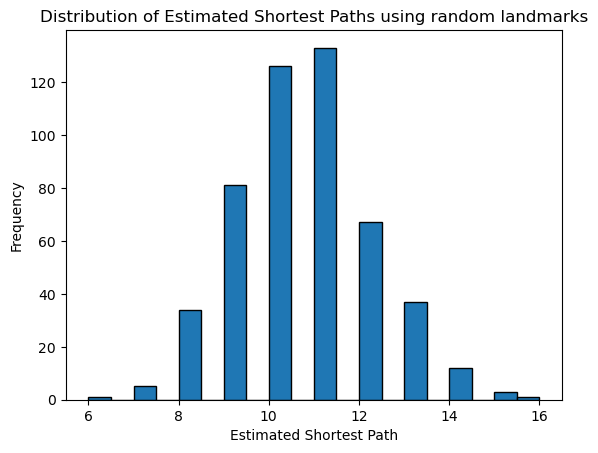

In [61]:
# Get the list of estimated shortest paths
estimations = list(estimated_shortest_paths.values())

# Plot the distribution
plt.hist(estimations, bins=20, edgecolor='black')
plt.xlabel('Estimated Shortest Path')
plt.ylabel('Frequency')
plt.title('Distribution of Estimated Shortest Paths using random landmarks')
plt.show()


# Degree landmarks / 1

In [62]:
# Workflow:
# Select landmarks
# Generate 500 random pairs of nodes
# Calculate shortest paths between each pair using landmarks

# Select landmarks
degree_landmarks = calculate_degree_centrality(G_dblp, 20)


random_node_pairs = generate_random_node_pairs(G_dblp, number_pairs=500)

# Calculate estimation of shortest paths between each pair using landmarks

estimated_shortest_paths = {}

# Calculate estimation of shortest paths between each pair using landmarks
for source, target in random_node_pairs:
    estimation = estimate_shortest_path(G_dblp, source, target, degree_landmarks)
    estimated_shortest_paths[(source, target)] = estimation

# Print the dictionary of estimated shortest paths
print(estimated_shortest_paths)



{(280646, 89029): 10, (290084, 217334): 9, (225375, 200261): 10, (219921, 116779): 8, (277389, 185077): 8, (62198, 289253): 9, (271779, 38694): 9, (295665, 194932): 10, (59563, 281037): 9, (155205, 276625): 9, (100090, 237887): 7, (112862, 74788): 7, (132650, 312276): 9, (5942, 175647): 5, (122257, 258347): 7, (311350, 116627): 7, (272244, 241425): 8, (210362, 256800): 11, (122836, 94604): 8, (53368, 223851): 7, (283626, 68477): 8, (218295, 145409): 5, (14536, 185912): 7, (56416, 210463): 8, (191230, 24904): 7, (64751, 112846): 7, (174839, 30924): 8, (69347, 79130): 10, (271257, 185935): 11, (242337, 246201): 8, (87429, 275930): 8, (129216, 292440): 6, (153384, 258662): 8, (76352, 192838): 7, (48980, 217046): 8, (202553, 81445): 7, (271889, 132035): 8, (171355, 65947): 6, (303679, 181181): 12, (188226, 221260): 9, (315199, 190267): 11, (129735, 91999): 7, (226947, 167757): 7, (263152, 268485): 8, (61415, 258654): 7, (117443, 175134): 8, (279790, 248719): 8, (95410, 295827): 10, (183012

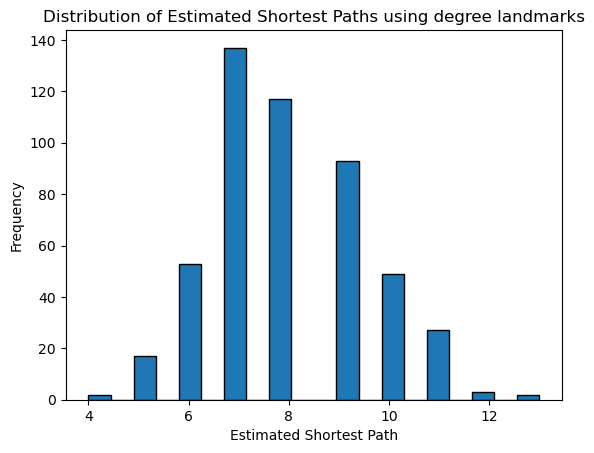

In [63]:
# Get the list of estimated shortest paths
estimations = list(estimated_shortest_paths.values())

# Plot the distribution
plt.hist(estimations, bins=20, edgecolor='black')
plt.xlabel('Estimated Shortest Path')
plt.ylabel('Frequency')
plt.title('Distribution of Estimated Shortest Paths using degree landmarks')
plt.show()


# Closeness landmarks / 1

In [46]:
# Workflow:
# Select landmarks
# Generate 500 random pairs of nodes
# Calculate shortest paths between each pair using landmarks

# Select landmarks
closeness_landmarks = calculate_closeness_centrality(G_dblp, N=20, num_seeds=20)


random_node_pairs = generate_random_node_pairs(G_dblp, number_pairs=500)

# Calculate estimation of shortest paths between each pair using landmarks

estimated_shortest_paths = {}

# Calculate estimation of shortest paths between each pair using landmarks
for source, target in random_node_pairs:
    estimation = estimate_shortest_path(G_dblp, source, target, closeness_landmarks)
    estimated_shortest_paths[(source, target)] = estimation

# Print the dictionary of estimated shortest paths
print(estimated_shortest_paths)



{(280229, 21948): 9, (287380, 202924): 9, (280533, 50646): 6, (101671, 175354): 7, (72461, 91723): 7, (20637, 25664): 6, (225197, 115909): 8, (37286, 227855): 7, (275324, 148489): 8, (93053, 197935): 8, (11846, 122206): 6, (27894, 95134): 7, (232953, 13171): 6, (250606, 246894): 10, (61243, 187196): 6, (176902, 58377): 7, (197986, 90668): 8, (155323, 159695): 6, (144365, 166252): 7, (15570, 125296): 6, (28227, 41978): 6, (227829, 105229): 10, (306052, 144999): 8, (202878, 177112): 8, (225068, 32306): 6, (233651, 240833): 11, (53726, 142655): 8, (263161, 46846): 6, (120729, 172222): 7, (167425, 49645): 8, (96794, 124542): 7, (232140, 185395): 7, (126802, 35705): 7, (32436, 173884): 7, (266869, 50810): 8, (55966, 63977): 7, (4560, 191011): 5, (131822, 238806): 7, (290773, 141034): 10, (300842, 199014): 11, (7136, 194995): 7, (98587, 273769): 7, (164057, 16300): 7, (305400, 112485): 7, (174687, 57189): 6, (293334, 21418): 8, (177843, 236588): 8, (55382, 52097): 7, (68694, 44617): 6, (3428

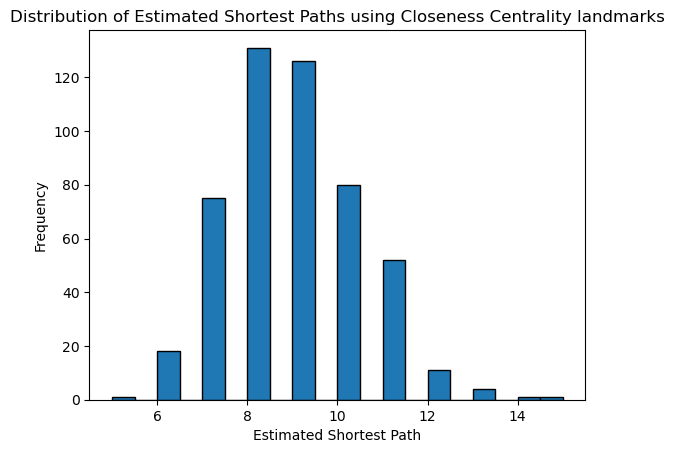

In [52]:
# Get the list of estimated shortest paths
estimations = list(estimated_shortest_paths.values())

# Plot the distribution
plt.hist(estimations, bins=20, edgecolor='black')
plt.xlabel('Estimated Shortest Path')
plt.ylabel('Frequency')
plt.title('Distribution of Estimated Shortest Paths using Closeness Centrality landmarks')
plt.show()


# Betweenness landmarks / 1

In [49]:
# Workflow:
# Select landmarks
# Generate 500 random pairs of nodes
# Calculate shortest paths between each pair using landmarks

# Select landmarks
betweenness_landmarks = calculate_betweenness_centrality(G_dblp, N=20, num_seeds=20)


random_node_pairs = generate_random_node_pairs(G_dblp, number_pairs=500)

# Calculate estimation of shortest paths between each pair using landmarks

estimated_shortest_paths = {}

# Calculate estimation of shortest paths between each pair using landmarks
for source, target in random_node_pairs:
    estimation = estimate_shortest_path(G_dblp, source, target, betweenness_landmarks)
    estimated_shortest_paths[(source, target)] = estimation

# Print the dictionary of estimated shortest paths
print(estimated_shortest_paths)



{(211363, 293178): 9, (270216, 176125): 10, (202743, 303940): 11, (82543, 118221): 8, (302002, 206011): 10, (181355, 142294): 8, (244655, 258407): 9, (165037, 53245): 6, (202537, 228239): 7, (78713, 206817): 9, (18217, 153687): 6, (184628, 19542): 6, (168586, 5097): 8, (89116, 27934): 10, (300912, 56681): 11, (44565, 141052): 7, (133823, 11693): 8, (240719, 288957): 10, (183324, 43278): 8, (29945, 296231): 8, (259946, 31182): 11, (13511, 96492): 7, (87338, 122604): 8, (304280, 182047): 10, (44847, 241837): 9, (288194, 169646): 10, (60673, 271539): 7, (280721, 186779): 10, (307159, 301425): 11, (176263, 189135): 8, (193129, 46779): 9, (301138, 21021): 8, (93337, 273704): 8, (85275, 249327): 9, (157373, 284392): 15, (249181, 107848): 9, (168221, 157338): 9, (128937, 263503): 9, (74194, 94255): 6, (224193, 227288): 10, (108743, 101321): 8, (144386, 306027): 8, (22040, 169887): 9, (316613, 301025): 10, (240594, 264454): 9, (73861, 136867): 9, (179664, 145400): 8, (277699, 258134): 11, (206

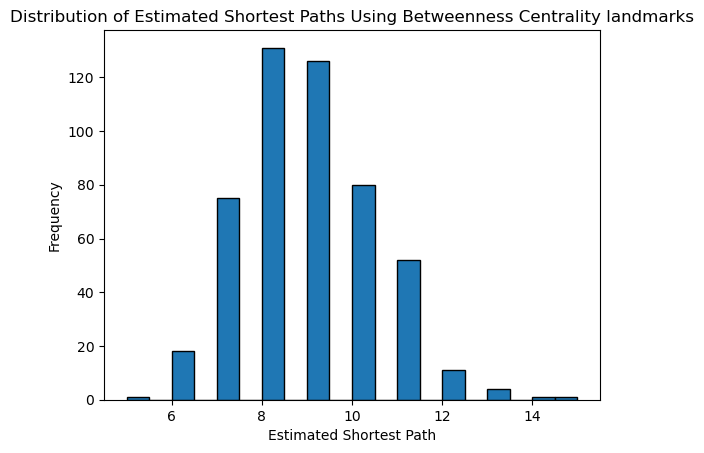

In [53]:
# Get the list of estimated shortest paths
estimations = list(estimated_shortest_paths.values())

# Plot the distribution
plt.hist(estimations, bins=20, edgecolor='black')
plt.xlabel('Estimated Shortest Path')
plt.ylabel('Frequency')
plt.title('Distribution of Estimated Shortest Paths Using Betweenness Centrality landmarks')
plt.show()
